1. Engine thrust lapse (TOC/TO) and (TOC/00)
2. Specific thrust at TOC vs. specific thrust at TO
3. Rate of specific thrust with TS

In [1]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'python'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna
from scipy import interpolate

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Definitions 
class Constants:
    """
    
    """

    def __init__(self):
        
        # Constants
        self.gamma = 1.4               # Ratio of specific heats [-]
        self.R = 287.                  # Gas constant air [J/kgK]
        self.Cp = self.gamma*self.R/(self.gamma-1)  # Specific heat at constant pressure [J/kgK]
        self.g = 9.80665               # Gravitational acceleration [m/s2]

        # Fuel constants
        self.LHV = 43e6                # Kerosene lower heating value [J/kg]

        # Sea level values of atmosphere
        self.rho_sl   = 1.225          # Sea level density [kg/m3]
        self.P_sl     = 101325         # Sea level pressure [Pa]
        self.T_sl     = 288.15         # Sea level temperature [K]
        self.lapse_sl = 0.0065         # Lapse rate troposphere [1/m]

        # z = 11km values of atmosphere
        self.rho_z11 = 0.363918       # h = 11km density [kg/m3]
        self.P_z11   = 22632.1        # h = 11km pressure [kg/m3]
        self.T_z11   = 216.65         # h = 11km temperature [kg/m3]

        # z = 20 values of atmosphere
        self.rho_z20   = 0.0880349    # Sea level density [kg/m3]
        self.P_z20     = 5474.89      # Sea level pressure [Pa]
        self.T_z20     = 216.650      # Sea level temperature [K]
        self.lapse_z20 = -0.0001      # Lapse rate troposphere [1/m]
        
class ACD:
    """
    The Aircraft Conceptual Design (ACD) module contains the methods for the conceptual design of aircraft from first principles.
    
    """

    def __init__(self) -> None:
        
        """
        :param mtow: maximum take-off weight [kg]
        :type mtow: float
        :param M_0: cruise Mach number [-]
        :type M_0: float
        :param N_e: number of engines [-]
        :type N_e: int
        """

        self.c = Constants()

    def compute_atmosphere(self, z): 
        """
        Calculate atmospheric properties at altitude z.
        
        :param z: altitude [m]
        :type z: np.ndarray
        
        :return: [T, p, rho, a]
        :rtype: list
        """
        
        ## Calculations
        T = np.zeros(np.size(z))
        rho = np.zeros(np.size(z))
        p = np.zeros(np.size(z))
        a = np.zeros(np.size(z))
        
        if np.size(z) == 1:
            z = [z]
        
        for i, height in enumerate(z):
            # Troposphere
            if height >= -100. and height <= 11000.:
                T[i]   = self.c.T_sl - self.c.lapse_sl*height
                p[i]   = self.c.P_sl * (T[i]/self.c.T_sl)**(self.c.g/self.c.lapse_sl/self.c.R)
                rho[i] = self.c.rho_sl * (T[i]/self.c.T_sl)**(self.c.g/self.c.lapse_sl/self.c.R-1)
            # Tropopause
            elif height > 11000. and height < 20000.: 
                T[i]   = self.c.T_z11
                p[i]   = self.c.P_z11 * np.exp(-self.c.g*(height-11000)/self.c.R/T[i])
                rho[i] = self.c.rho_z11 * np.exp(-self.c.g*(height-11000)/self.c.R/T[i])
            # Stratosphere
            elif height >=20000. and height < 32000:
                T[i]   = self.c.T_z20 - self.c.lapse_z20*(height-20000)   
                p[i]   = self.c.P_z20 * (T[i]/self.c.T_z20)**(self.c.g/self.c.lapse_z20/self.c.R)
                rho[i] = self.c.rho_z20 * (T[i]/self.c.T_z20)**(self.c.g/self.c.lapse_z20/self.c.R-1)
            else:
                raise ValueError('Altitude is out of bounds (-100 < z < 32000) m.')

            a[i] = np.sqrt(self.c.gamma*self.c.R*T[i])
        
        if np.size(z) == 1:
            return T[0], p[0], rho[0], a[0]
        else:
            return T, p, rho, a
        
acd = ACD()

In [3]:
# Sweeps (STCA) / (GT Medium SST) 
W_S_lst = np.linspace(3500, 5000, 7)
F_W_lst = np.linspace(0.325, 0.475, 7)

case_lst = ['scaling', 'scaling_all_constant_LD6', 'scaling_all_constant_LD6_mid']
clmax_lst = dict()
LDmax_lst = dict()
for k,case in enumerate(case_lst):
    clmax_lst[case] = np.array([1.2, 1.2, 1.2])[k]
    LDmax_lst[case] = np.array([6.718101501415649, 6.718101501415649, 6.718101501415649])[k]
    
k_to = 1.4

In [5]:
# Compute F_ratio 
py = pyna()
py.case_name = 'stca'
py.initialize()

# Load engine deck
py.engine.get_performance_deck_variables(True, True, True, True, True)
py.engine.get_performance_deck(atmosphere_type='stratified', thrust_lapse=True, F00=None)

# Create engine deck interpolant
F_n_interp = interpolate.RegularGridInterpolator((py.engine.deck['z'], py.engine.deck['M_0'], py.engine.deck['TS']), py.engine.deck['F_n'])

case = 'scaling_all_constant_LD6_mid'

for W_S in W_S_lst: 
    c_l_max = clmax_lst[case]
    v_stall = np.sqrt(2*W_S/1.225/c_l_max)
    v_max = 1.4*v_stall

    F_ratio_sl = (F_n_interp((0, v_max/340.3, 1))/F_n_interp((0, 0, 1)))
    F_ratio_z  = (F_n_interp((1000, v_max/336.4, 1))/F_n_interp((0, 0, 1)))
    F_ratio = (F_ratio_sl+F_ratio_z)/2

#     print(F_ratio)
    
# Result: choose F/FSLS = 0.782

In [12]:
# Compute trajectories for (z-TS) sweep 
if False:
    ac_name = 'stca'
    case = 'scaling_all_constant_LD6_mid'

    for W_S in W_S_lst:    
        for F_W in F_W_lst:

            # W_S = W_S_lst[6]
            # F_W = F_W_lst[3]

            W = 55000*9.81

            c_l_max = clmax_lst[case]
            v_stall = np.sqrt(2*W_S/1.225/c_l_max)
            v_max = 1.4*v_stall

            pyna_settings = pyna.load_settings(case_name=ac_name)
            pyna_settings.ac_name = ac_name
            pyna_settings.case_name = ac_name
            pyna_settings.engine_file_name = 'engine_deck_' + ac_name + '.csv'
            pyna_settings.save_results = True
            pyna_settings.output_directory_name = case
            pyna_settings.max_iter = 200
            pyna_settings.TS_to = 1.0
            pyna_settings.TS_vnrs = 1.0
            pyna_settings.PKROT = True
            pyna_settings.engine_thrust_lapse = False
            pyna_settings.atmosphere_type = 'sealevel'

            pyna_settings.theta_flaps = 10.
            pyna_settings.theta_slats = -6.

            # pyna_settings.theta_flaps = 26.
            # pyna_settings.theta_slats = -26.

            pyna_settings.TS_cutback = 1.
            pyna_settings.z_cutback = 455.
            pyna_settings.output_file_name = pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'

            pyna_settings.Foo = F_W*W/3*F_ratio

            # Compute trajectory 
            py = pyna(pyna_settings)
            py.ac.v_max = v_max
            py.ac.z_max

            py.ac.af_S_w = W/W_S

            converged = py.compute_trajectory(trajectory_mode='cutback', objective='t_end')

            # Save timeseries
            path_save_name = 'trajectory_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
            engine_save_name = 'engine_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
            py.save_time_series(py.problem, py.settings, py.ac, path_save_name, engine_save_name)

In [13]:
# Compute noise for trajectories 
if False:
    ac_name = 'stca'
        
    # Case 2
    case = 'scaling_all_constant_LD6'
    n_sl = 131
    epnl_sideline = np.zeros((np.size(F_W_lst), np.size(W_S_lst), n_sl))
    epnl_lateral = np.zeros((np.size(F_W_lst), np.size(W_S_lst)))
    epnl_flyover = np.zeros((np.size(F_W_lst), np.size(W_S_lst)))

    pyna_settings = pyna.load_settings(case_name=ac_name)
    pyna_settings.ac_name = ac_name
    pyna_settings.output_directory_name = case

    for j, W_S in enumerate(W_S_lst):    
        for i, F_W in enumerate(F_W_lst):

            pyna_settings.engine_file_name = 'engine_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
            pyna_settings.trajectory_file_name = 'trajectory_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
            pyna_settings.lateral_attenuation = True
            pyna_settings.observer_lst = ['contours',]

            x_observer_lst = np.zeros((n_sl+1, 3))
            x_observer_lst[:-1, 0] = np.linspace(0, 6500, n_sl)
            x_observer_lst[:-1, 1] = 450*np.ones(n_sl)
            x_observer_lst[:, 2] = 4*0.3048*np.ones(n_sl+1)
            x_observer_lst[-1,0] = 6500.

            pyna_settings.x_observer_array = x_observer_lst

            py = pyna(pyna_settings)
            py.compute_noise_time_series()

            epnl_sideline[i,j,:] = py.problem.get_val('noise.epnl')[:-1]
            epnl_lateral[i,j] = np.max(py.problem.get_val('noise.epnl')[:-1])
            epnl_flyover[i,j] = py.problem.get_val('noise.epnl')[-1]

    np.save('../cases/'+ac_name+'/output/'+case+'/sweeps/epnl_lateral.npy', epnl_lateral)
    np.save('../cases/'+ac_name+'/output/'+case+'/sweeps/epnl_flyover.npy', epnl_flyover)
    np.save('../cases/'+ac_name+'/output/'+case+'/sweeps/epnl_sideline.npy', epnl_sideline)

    clear_output()

In [6]:
# Load trajectories 
ac_name = 'stca'
py.ac_name = ac_name

data = dict()

for k, case in enumerate(case_lst): 
    
    data[case] = dict()
    
    for W_S in W_S_lst:

        data[case][W_S] = dict()

        for F_W in F_W_lst:

            if case == 'scaling':
                py.output_directory_name = 'scaling'
                py.output_file_name = py.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'
                py.engine_file_name = 'engine_' + py.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
                py.trajectory_file_name = 'trajectory_' + py.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'

                data[case][W_S][F_W] = pd.read_csv('../cases/'+ac_name+'/trajectory/scaling/'+py.trajectory_file_name)

            if case == 'scaling_all_constant_LD6':
                py.output_directory_name = 'scaling_all_constant_LD6'
                py.output_file_name = py.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'
                py.engine_file_name = 'engine_' + py.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
                py.trajectory_file_name = 'trajectory_' + py.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'

                data[case][W_S][F_W] = pd.read_csv('../cases/'+ac_name+'/trajectory/scaling_all_constant_LD6/'+py.trajectory_file_name)
                 
            if case == 'scaling_all_constant_LD6_mid':
                py.output_directory_name = 'scaling_all_constant_LD6_mid'
                py.output_file_name = py.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'
                py.engine_file_name = 'engine_' + py.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
                py.trajectory_file_name = 'trajectory_' + py.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'

                data[case][W_S][F_W] = pd.read_csv('../cases/'+ac_name+'/trajectory/scaling_all_constant_LD6_mid/'+py.trajectory_file_name)


In [9]:
# Figure 6.6 (a)
if False:
    fig, ax = plt.subplots(2,2, figsize=(18, 8))
    plt.style.use('../utils/plot.mplstyle')

    if not scaling:
        ax[0,0].annotate(s='Flyover microphone', xy=(7000, 50), fontsize=18)
     
    case_lst_plot = ['scaling_all_constant_LD6']
    
    for iii, case in enumerate(case_lst_plot):

        for i,W_S in enumerate(W_S_lst):
            for j,F_W in enumerate(F_W_lst):

                x_group     = 1.
                t_group     = 1.
                z_group     = 1.
                v_group     = 1.
                gamma_group = 1.
                alpha_group = 1.  

                ax[0,0].plot([6500*x_group], [0], 'o', markersize=5, markeredgecolor='black', markerfacecolor='grey')

                ax[0,0].plot(data[case][W_S][F_W]['X [m]'].values*x_group, data[case][W_S][F_W]['Z [m]'].values*z_group)
                ax[0,1].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['V [m/s]'].values*v_group)
                ax[1,0].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['gamma [deg]'].values*gamma_group)
                ax[1,1].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['alpha [deg]'].values*alpha_group)

    ax[0,0].set_xlabel('$X$ [m]')
    ax[0,0].set_ylabel('$Z$ [m]')
    ax[0,1].set_xlabel('$t$ [s]')
    ax[0,1].set_ylabel('$V$ [m/s]')
    ax[1,0].set_xlabel('$t$ [s]')
    ax[1,0].set_ylabel(r'$\gamma$ [deg]')
    ax[1,1].set_xlabel('$t$ [s]')
    ax[1,1].set_ylabel(r'$\alpha$ [deg]')
    
    plt.subplots_adjust(hspace=0.4)

In [92]:
# Figure 6.6 (b)
if False:
    fig, ax = plt.subplots(2,2, figsize=(18, 8))
    plt.style.use('../utils/plot.mplstyle')

    ax[0,0].annotate(s='Flyover microphones', xy=(0.5, 0.07), fontsize=18)
    
    case_lst_plot = ['scaling_all_constant_LD6']
    
    for iii, case in enumerate(case_lst_plot):

        for i,W_S in enumerate(W_S_lst):
            for j,F_W in enumerate(F_W_lst):

                x_group     = F_W / W_S * clmax_lst[case] / k_to**2
                t_group     = F_W / np.sqrt(W_S/clmax_lst[case]) / k_to
                z_group     = F_W / W_S * clmax_lst[case]/(F_W-1/LDmax_lst[case]) / k_to**2
                v_group     = 1/np.sqrt(W_S/clmax_lst[case])/ k_to
                gamma_group = (np.pi/180)/(F_W-1/LDmax_lst[case])
                alpha_group = (np.pi/180)

                ax[0,0].plot([6500*x_group], [0], 'o', markersize=5, markeredgecolor='black', markerfacecolor='grey')

                ax[0,0].plot(data[case][W_S][F_W]['X [m]'].values*x_group, data[case][W_S][F_W]['Z [m]'].values*z_group)
                ax[0,1].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['V [m/s]'].values*v_group)
                ax[1,0].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['gamma [deg]'].values*gamma_group)
                ax[1,1].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['alpha [deg]'].values*alpha_group)
              
        ax[0,0].plot([0, 0.1, 1.], [0, 0, np.tan(0.815)*(1.-0.1)], 'k--')
            
        ax[0,0].set_xlabel('$X^*$')
        ax[0,0].set_ylabel('$Z^*$')
        ax[0,0].set_ylim([-0.1, 1])
        ax[0,1].set_xlabel('$t^*$')
        ax[0,1].set_ylabel('$V^*$')
        ax[0,1].set_ylim([-0.1, 2])
        ax[1,0].set_xlabel('$t^*$')
        ax[1,0].set_ylabel(r'$\gamma^*$')
        ax[1,0].set_ylim([-0.1, 1.1])
        ax[1,1].set_xlabel('$t^*$')
        ax[1,1].set_ylabel(r'$\alpha^*$')
        
    plt.subplots_adjust(hspace=0.4)

In [99]:
# Figure 6.7 (a)
if False:
    fig, ax = plt.subplots(2,2, figsize=(18, 8))
    plt.style.use('../utils/plot.mplstyle')

    ax[0,0].annotate(s='Flyover microphones', xy=(0.5, 0.05), fontsize=18)
    
    case_lst_plot = ['scaling']
    
    for iii, case in enumerate(case_lst_plot):

        for i,W_S in enumerate(W_S_lst):
            for j,F_W in enumerate(F_W_lst):

                x_group     = F_W / W_S * clmax_lst[case] / k_to**2
                t_group     = F_W / np.sqrt(W_S/clmax_lst[case]) / k_to
                z_group     = F_W / W_S * clmax_lst[case]/(F_W-1/LDmax_lst[case]) / k_to**2
                v_group     = 1/np.sqrt(W_S/clmax_lst[case])/ k_to
                gamma_group = (np.pi/180)/(F_W-1/LDmax_lst[case])
                alpha_group = (np.pi/180)
                    
                ax[0,0].plot([6500*x_group], [0], 'o', markersize=5, markeredgecolor='black', markerfacecolor='grey')
                
                ax[0,0].plot(data[case][W_S][F_W]['X [m]'].values*x_group, data[case][W_S][F_W]['Z [m]'].values*z_group)
                ax[0,1].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['V [m/s]'].values*v_group)
                ax[1,0].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['gamma [deg]'].values*gamma_group)
                ax[1,1].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['alpha [deg]'].values*alpha_group)
    
        ax[0,0].set_xlabel('$X^*$')
        ax[0,0].set_ylabel('$Z^*$')
        ax[0,0].set_ylim([-0.1, 1])
        ax[0,1].set_xlabel('$t^*$')
        ax[0,1].set_ylabel('$V^*$')
        ax[0,1].set_ylim([-0.1, 2])
        ax[1,0].set_xlabel('$t^*$')
        ax[1,0].set_ylabel(r'$\gamma^*$')
        ax[1,0].set_ylim([-0.1, 1.1])
        ax[1,1].set_xlabel('$t^*$')
        ax[1,1].set_ylabel(r'$\alpha^*$')

    # Plot dashed line
    W_S = 3500.
    F_W = 0.40
    
    x_group     = F_W / W_S * clmax_lst[case] / k_to**2
    t_group     = F_W / np.sqrt(W_S/clmax_lst[case]) / k_to
    z_group     = F_W / W_S * clmax_lst[case]/(F_W-1/LDmax_lst[case]) / k_to**2
    v_group     = 1/np.sqrt(W_S/clmax_lst[case])/ k_to
    gamma_group = (np.pi/180)/(F_W-1/LDmax_lst[case])
    alpha_group = (np.pi/180)
                
    ax[0,0].plot([0, 0.1, 1.2], [0, 0, np.tan(0.817)*(1.2-0.1)], 'k--')
#     ax[0,0].plot([0, 0.13, 1.2], [0, 0, np.tan(0.54)*(1.2-0.13)], 'k--')
#     ax[0,0].plot(data['scaling_all_constant_LD6'][W_S][F_W]['X [m]'].values*x_group, data['scaling_all_constant_LD6'][W_S][F_W]['Z [m]'].values*z_group, 'k--')
    ax[0,1].plot(data['scaling_all_constant_LD6'][W_S][F_W]['t_source [s]'].values*t_group, data['scaling_all_constant_LD6'][W_S][F_W]['V [m/s]'].values*v_group, 'k--')
    ax[1,0].plot(data['scaling_all_constant_LD6'][W_S][F_W]['t_source [s]'].values*t_group, data['scaling_all_constant_LD6'][W_S][F_W]['gamma [deg]'].values*gamma_group, 'k--')
    ax[1,1].plot(data['scaling_all_constant_LD6'][W_S][F_W]['t_source [s]'].values*t_group, data['scaling_all_constant_LD6'][W_S][F_W]['alpha [deg]'].values*alpha_group, 'k--')
    
    ax[0,0].annotate(s='Scaling rule', xy=(0.33, 0.64), fontsize=18)
    ax[0,1].annotate(s='Scaling rule', xy=(0.5, 1.42), fontsize=18)
    ax[1,0].annotate(s='Scaling rule', xy=(0.65, 0.89), fontsize=18)
    ax[1,1].annotate(s='Scaling rule', xy=(0.5, 0.18), fontsize=18)
    ax[0,1].plot([0.43, 0.485], [1.28, 1.48], 'k', linewidth=1)
    
    plt.subplots_adjust(hspace=0.4)

In [109]:
# Figure 6.7 (b)
if False:
    fig, ax = plt.subplots(2,2, figsize=(18, 8))
    plt.style.use('../utils/plot.mplstyle')

    ax[0,0].annotate(s='Flyover microphones', xy=(0.5, 0.05), fontsize=18)
    
    case_lst_plot = ['scaling']
    
    for iii, case in enumerate(case_lst_plot):

        for i,W_S in enumerate(W_S_lst):
            for j,F_W in enumerate(F_W_lst):

                x_group     = F_W / W_S * clmax_lst[case] / k_to**2
                t_group     = F_W / np.sqrt(W_S/clmax_lst[case]) / k_to
                z_group     = F_W / W_S * clmax_lst[case]/(F_W-1/LDmax_lst[case]) / k_to**2
                v_group     = 1/np.sqrt(W_S/clmax_lst[case])/ k_to
                gamma_group = (np.pi/180)/(F_W-1/LDmax_lst[case])
                alpha_group = (np.pi/180)
                    
                ax[0,0].plot([6500*x_group], [0], 'o', markersize=5, markeredgecolor='black', markerfacecolor='grey')
                
                ax[0,0].plot(data[case][W_S][F_W]['X [m]'].values*x_group, data[case][W_S][F_W]['Z [m]'].values*z_group)
                ax[0,1].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['V [m/s]'].values*v_group)
                ax[1,0].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['gamma [deg]'].values*gamma_group)
                ax[1,1].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['alpha [deg]'].values*alpha_group)
    
        ax[0,0].set_xlabel('$X^*$')
        ax[0,0].set_ylabel('$Z^*$')
        ax[0,0].set_ylim([-0.1, 1])
        ax[0,1].set_xlabel('$t^*$')
        ax[0,1].set_ylabel('$V^*$')
        ax[0,1].set_ylim([-0.1, 2])
        ax[1,0].set_xlabel('$t^*$')
        ax[1,0].set_ylabel(r'$\gamma^*$')
        ax[1,0].set_ylim([-0.1, 1.1])
        ax[1,1].set_xlabel('$t^*$')
        ax[1,1].set_ylabel(r'$\alpha^*$')

    # Plot dashed line
    W_S = 3500.
    F_W = 0.40
    
    x_group     = F_W / W_S * clmax_lst[case] / k_to**2
    t_group     = F_W / np.sqrt(W_S/clmax_lst[case]) / k_to
    z_group     = F_W / W_S * clmax_lst[case]/(F_W-1/LDmax_lst[case]) / k_to**2
    v_group     = 1/np.sqrt(W_S/clmax_lst[case])/ k_to
    gamma_group = (np.pi/180)/(F_W-1/LDmax_lst[case])
    alpha_group = (np.pi/180)
                
#     ax[0,0].plot([0, 0.1, 1.2], [0, 0, np.tan(0.817)*(1.2-0.1)], 'k--')
    ax[0,0].plot([0, 0.13, 1.25], [0, 0, np.tan(0.54)*(1.25-0.13)], 'k--')
#     ax[0,0].plot(data['scaling_all_constant_LD6'][W_S][F_W]['X [m]'].values*x_group, data['scaling_all_constant_LD6'][W_S][F_W]['Z [m]'].values*z_group, 'k--')
    ax[0,1].plot(data['scaling_all_constant_LD6_mid'][W_S][F_W]['t_source [s]'].values*t_group, data['scaling_all_constant_LD6_mid'][W_S][F_W]['V [m/s]'].values*v_group, 'k--')
    ax[1,0].plot(data['scaling_all_constant_LD6_mid'][W_S][F_W]['t_source [s]'].values*t_group, data['scaling_all_constant_LD6_mid'][W_S][F_W]['gamma [deg]'].values*gamma_group, 'k--')
    ax[1,1].plot(data['scaling_all_constant_LD6_mid'][W_S][F_W]['t_source [s]'].values*t_group, data['scaling_all_constant_LD6_mid'][W_S][F_W]['alpha [deg]'].values*alpha_group, 'k--')
    
    ax[0,0].annotate(s='Scaling rule', xy=(0.79, 0.64), fontsize=18)
    ax[0,1].annotate(s='Scaling rule', xy=(0.5, 1.42), fontsize=18)
    ax[1,0].annotate(s='Scaling rule', xy=(0.65, 0.74), fontsize=18)
    ax[1,1].annotate(s='Scaling rule', xy=(0.5, 0.18), fontsize=18)
    ax[0,1].plot([0.43, 0.485], [1.28, 1.48], 'k', linewidth=1)
    
    plt.subplots_adjust(hspace=0.4)

In [112]:
# Assessment of the scaling rule for the flyover distance 
# Compute minimum distance between microphone and trajectory and source noise 
r_fly = dict()

for k,case in enumerate(case_lst): 
    r_fly[case] = dict()
    r_fly[case] = np.zeros((np.size(F_W_lst), np.size(W_S_lst)))
    
    for j,W_S in enumerate(W_S_lst):
        for i,F_W in enumerate(F_W_lst):
            # Compute distance to flyover microphone
            dist = np.sqrt((data[case][W_S][F_W]['X [m]'].values-6500)**2+(data[case][W_S][F_W]['Z [m]'].values-0)**2)
            r_fly[case][i,j] = np.min(dist)

In [113]:
def compute_flyover_distance(x_pp, theta, F00_W, W_S, LD_to, c_l_max, k_to, TS):

    theta = theta * (TS*F00_W-1/LD_to)/(F00_W-1/LD_to)
    
    r_fly = (6500-x_pp*k_to**2*W_S/F00_W/c_l_max) * (F00_W-1/LD_to)*np.sin(theta)/np.sqrt((F00_W-1/LD_to)**2*np.sin(theta)**2 + np.cos(theta)**2)
    
    return r_fly

In [115]:
# Assessment of the scaling rule for the flyover distance 
# Compute minimum distance between microphone and trajectory and source noise 
r_fly_scaling = dict()
r_fly_scaling_u = dict()

for k,case in enumerate(case_lst): 
    r_fly_scaling[case] = dict()
    r_fly_scaling[case] = np.zeros((np.size(F_W_lst), np.size(W_S_lst)))
    r_fly_scaling_u[case] = dict()
    r_fly_scaling_u[case] = np.zeros((np.size(F_W_lst), np.size(W_S_lst)))
    
    for j,W_S in enumerate(W_S_lst):
        for i,F_W in enumerate(F_W_lst):
            # Compute distance to flyover microphone
            r_fly_scaling[case][i,j] = compute_flyover_distance(x_pp=0.1, theta=0.817, F00_W=F_W, W_S=W_S, LD_to=LDmax_lst[case], c_l_max=clmax_lst[case], k_to=1.4, TS=1)
            r_fly_scaling_u[case][i,j] = compute_flyover_distance(x_pp=0.13, theta=0.54, F00_W=F_W, W_S=W_S, LD_to=LDmax_lst[case], c_l_max=clmax_lst[case], k_to=1.4, TS=1)

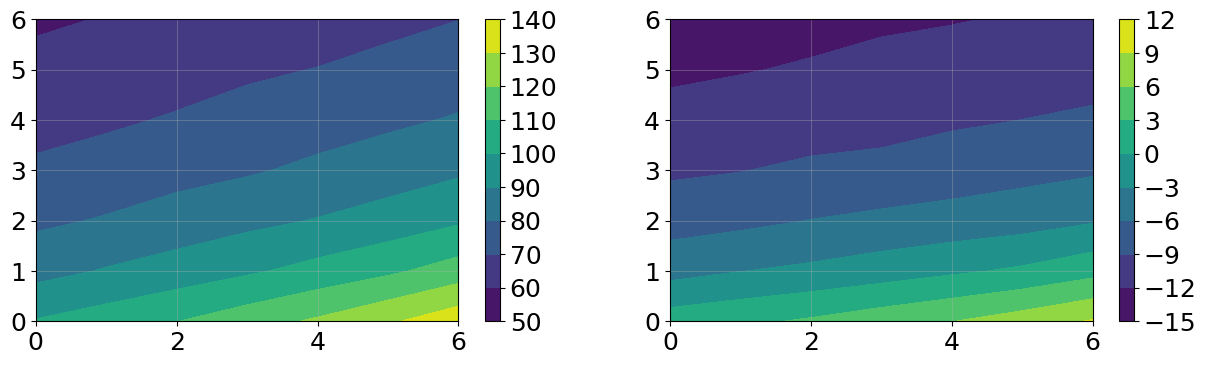

In [121]:
# Plot error between scaling rule and actual trajectories
fig,ax = plt.subplots(1,2, figsize=(15,4))
c0 = ax[0].contourf((r_fly_scaling['scaling_all_constant_LD6']-r_fly['scaling'])/r_fly['scaling']*100)
plt.colorbar(c0, ax=ax[0])

c1 = ax[1].contourf((r_fly_scaling_u['scaling_all_constant_LD6']-r_fly['scaling'])/r_fly['scaling']*100)
plt.colorbar(c1, ax=ax[1])

In [123]:
# Compute source noise and propagation noise for the take-off trajectories
r_min = dict()

L_src = dict()
L_prop = dict()

for k,case in enumerate(case_lst): 
    r_min[case] = dict()
    r_min[case] = np.zeros((np.size(F_W_lst), np.size(W_S_lst)))

    L_src[case] = np.zeros((np.size(F_W_lst), np.size(W_S_lst)))
    
    L_prop[case] = dict()
    L_prop[case] = np.zeros((np.size(F_W_lst), np.size(W_S_lst)))
    
    for j,W_S in enumerate(W_S_lst):
        for i,F_W in enumerate(F_W_lst):
    
            # Compute distance to flyover microphone
            dist = np.sqrt((data[case][W_S][F_W]['X [m]'].values-6500)**2+(data[case][W_S][F_W]['Z [m]'].values-0)**2)
            r_min[case][i,j] = np.min(dist)
                        
            # Compute source strength
            V_j = 410
            V_0 = 1.4*np.sqrt(2*W_S/1.225/clmax_lst[case])
            L_src[case][i,j] = 80*np.log10(V_j-V_0)
            
            # Compute propagation levels
            L_prop[case][i,j] = 20*np.log10(1/r_min[case][i,j])

In [124]:
# Load noise sweeps for take-off trajectories
epnl = dict()
for case in case_lst:
    epnl[case] = dict()
    
    for mic in ['lateral', 'flyover', 'sideline']:
        epnl[case][mic] = np.load('../cases/stca/output/'+case+'/sweeps/epnl_'+mic+'.npy')

In [140]:
# Get proportionality coefficients for scaling rule 
def get_error_model(x, L_src, L_prop, epnl_fly):
    
    e = 0
    for j,W_S in enumerate(W_S_lst):
        for i,F_W in enumerate(F_W_lst):
            
            e += ( epnl_fly[i,j] - (x[0]*L_src[i,j] + x[1]*L_prop[i,j]) )**2
                             
    return e

import scipy
x = dict()
for case in case_lst:
    x[case]=scipy.optimize.minimize(get_error_model, [1,1], args=(L_src[case], L_prop[case], epnl[case]['flyover']), method='Nelder-Mead')

x_opt = x['scaling'].x

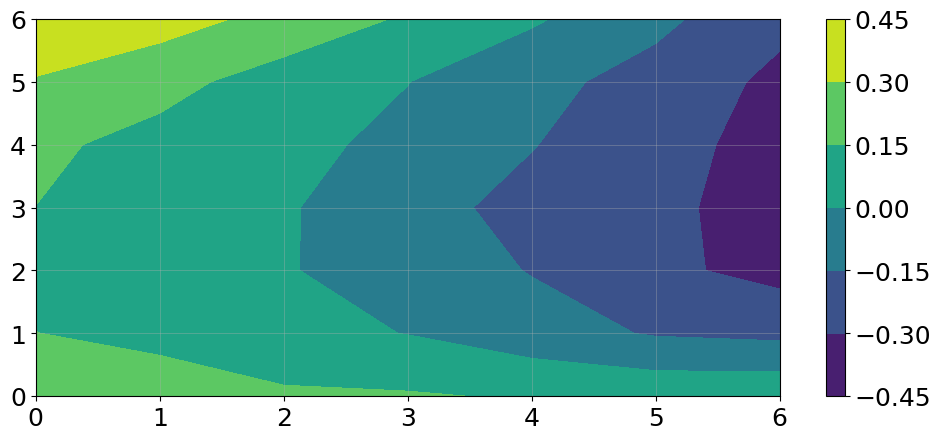

In [150]:
# Error for proportionality coefficients
L_scaling = x_opt[0]*L_src['scaling'] + x_opt[1]*L_prop['scaling']
plt.contourf((L_scaling-epnl['scaling']['flyover'])/epnl['scaling']['flyover']*100)
plt.colorbar()